In [7]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [2]:
def select_model(input):
  source = {'CodeBERT_small' : {'tokenizer' : "huggingface/CodeBERTa-small-v1", 'model':"huggingface/CodeBERTa-small-v1"},
            'CodeBERT' : {'tokenizer' : "microsoft/codebert-base", 'model':"microsoft/codebert-base"},
            'GraphCodeBERT' : {'tokenizer' : "microsoft/graphcodebert-base", 'model':"microsoft/graphcodebert-base"},
            'Fine-tuning_Example' : {'tokenizer':"mrm8488/codebert-finetuned-clone-detection", 'model':"mrm8488/codebert-finetuned-clone-detection"}
  }
  
  if input in source.keys():
    tokenizer = source[input]['tokenizer']
    model = source[input]['model']
  else:
    print('Return None Obejects')
    print('Models :', source.keys())
    return None, None
  
  return tokenizer, model

In [3]:
tokenizer_path, model_path = select_model('CodeBERT')

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

In [4]:
from torch.utils.data import Dataset, DataLoader

class Code():
    def __init__(self, path, test_size):
        self.path = path
        self.test_size = test_size
            
    def openFile(self):
        df = pd.read_csv(self.path+'sample_train.csv')
        df = df.sample(frac=1).reset_index(drop=True) # shuffle

        # dataframe to ndarray
        ndarray = pd.DataFrame.to_numpy(df)

        # train/valid/test
        train = ndarray[:-2*self.test_size]
        valid = ndarray[-2*self.test_size:-self.test_size]
        test = ndarray[-self.test_size:]

        return train, valid, test

class code_dataset(Dataset):
    def __init__(self, data):

        input_ids = []
        attn_masks = []

        for i in range(len(data)):
            tmp = tokenizer(data[i, 0], data[i,1], padding='max_length', truncation=True, return_tensors='pt')
            input_ids.append(tmp['input_ids'])
            attn_masks.append(tmp['attention_mask'])
        
        self.input_ids = torch.cat(input_ids, out=torch.Tensor(len(input_ids), 512)).type(torch.LongTensor)
        self.attn_masks = torch.cat(attn_masks, out=torch.Tensor(len(attn_masks), 512)).type(torch.LongTensor)
        self.labels =  torch.from_numpy(data[:, 2].astype(int))

    def __getitem__(self, index):
        return self.input_ids[index], self.attn_masks[index], self.labels[index]

    def __len__(self):
        return len(self.labels)

def dataset_loader(path, test_size, batch_size):
    code = Code(path, test_size=test_size)

    train, valid, test = code.openFile()

    train_dataset = code_dataset(train)
    valid_dataset = code_dataset(valid)
    test_dataset = code_dataset(test)

    train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

    return train_loader, valid_loader, test_loader

def dataloader_testing():
    # dataloader test
    path = './'
    train_loader, valid_loader, test_loader = dataset_loader(path, test_size=1000, batch_size=3) # batch_size = 3 (toy example)

    data = next(iter(train_loader))

    print('Batch Size :', len(data[0]))
    print('input_ids: ', type(data[0]),'\n', data[0])
    print('attn_masks :', type(data[1]),'\n', data[1])
    print('labels :', type(data[2]),'\n', data[2])

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(model_path, return_dict=False, num_labels=2)

Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be 

In [6]:
path = './'
train_loader, valid_loader, test_loader = dataset_loader(path, test_size=1000, batch_size=16)

In [8]:
loss_fn = nn.BCELoss()

def cal_acc_and_loss(device, total_logits, labels_for_loss, pred, true):
    correct = 0
    count = 0
    total_loss = 0
    num_batch = 0

    for i in range(len(pred)):
        pred_i = pred[i]
        true_i = true[i]
        # print(pred_i.shape)
        # print(true_i.shape)
        
        correct += np.sum(pred_i == true_i)
        # print(total_logits[i].shape)
        # print(total_logits[i])
        # print(labels_for_loss[i].shape)
        # print(labels_for_loss[i])
        total_loss += loss_fn(total_logits[i].to('cpu'), labels_for_loss[i].to('cpu').float())

        count += len(pred_i)
        num_batch += 1
    
    acc = correct/count
    loss = total_loss/num_batch

    return correct, total_loss, count, num_batch, acc, loss

In [9]:
def performance(model, device, data_loader):
    total_logits, labels_for_loss, predictions , true_labels = [], [], [], []

    for batch in data_loader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        label_ids = b_labels

        activation = nn.Softmax(dim=1)
        logits = activation(logits)
        
        tmp_logits = torch.max(logits, dim=1)

        logits = torch.abs(tmp_logits[0] + tmp_logits[1]-1)
        pred = tmp_logits[1]

        pred = pred.detach().cpu().numpy()

        total_logits.append(logits)
        labels_for_loss.append(label_ids)
        predictions.append(pred)
        true_labels.append(label_ids.to('cpu').numpy())

    correct, total_loss, count, num_batch, acc, loss = cal_acc_and_loss(device, total_logits, labels_for_loss, predictions, true_labels)

    return acc, round(float(loss), 4)

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

num_epochs = 3
step_count = 0
total_steps = num_epochs * len(train_loader)

model = model.to(device)

train_acc = []
valid_acc = []
train_loss = []
valid_loss = []

loss_over_10_steps = []

for epoch in range(num_epochs):
    for i, (input_ids, attn_masks, labels) in enumerate(train_loader):
        model.train()

        optimizer.zero_grad()

        input_ids = input_ids.to(device)
        attn_masks = attn_masks.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, token_type_ids=None, attention_mask=attn_masks, labels=labels)

        loss = outputs[0]

        loss.backward()
        
        loss_over_10_steps.append(loss.item())

        optimizer.step()

        if step_count%10 == 0:
            print('Step {} over {}'.format(step_count, total_steps))
            print(' Train Loss : ', np.mean(loss_over_10_steps))
            train_loss.append(np.mean(loss_over_10_steps))
            loss_over_10_steps = []
        
        # Report Validation Performance
        model.eval()
        if step_count%100 == 0:
            val_acc, val_loss = performance(model, device, valid_loader)
            print('     Report Performance on Validation Dataset...')
            print('     Valid Loss :', val_loss)
            print('     Valid Acc  :', val_acc)
            valid_acc.append(val_acc)
            valid_loss.append(val_loss)
        
        step_count = step_count + 1

Step 0 over 2997
 Train Loss :  0.7188475728034973
     Report Performance on Validation Dataset...
     Valid Loss : 0.7009
     Valid Acc  : 0.519
Step 10 over 2997
 Train Loss :  0.7159981369972229
Step 20 over 2997
 Train Loss :  0.6920201182365417
Step 30 over 2997
 Train Loss :  0.6840802550315856
Step 40 over 2997
 Train Loss :  0.6905726253986358
Step 50 over 2997
 Train Loss :  0.7004240214824676
Step 60 over 2997
 Train Loss :  0.7008298456668853
Step 70 over 2997
 Train Loss :  0.6916822552680969
Step 80 over 2997
 Train Loss :  0.6896902799606324
Step 90 over 2997
 Train Loss :  0.6973025977611542
Step 100 over 2997
 Train Loss :  0.6978369534015656
     Report Performance on Validation Dataset...
     Valid Loss : 0.6852
     Valid Acc  : 0.597
Step 110 over 2997
 Train Loss :  0.6847529113292694
Step 120 over 2997
 Train Loss :  0.6918510735034943
Step 130 over 2997
 Train Loss :  0.6884332656860351
Step 140 over 2997
 Train Loss :  0.6914479672908783
Step 150 over 2997
 

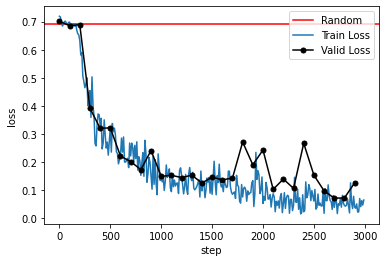

In [19]:
import matplotlib.pyplot as plt

train_x_axis = [10*i for i in range(len(train_loss))]
valid_x_axis = [100*i for i in range(len(valid_loss))]

plt.axhline(y=0.69, label='Random', color='red')
plt.plot(train_x_axis, train_loss, label='Train Loss')
plt.plot(valid_x_axis, valid_loss, marker='o', ms=5, color='black', label='Valid Loss')

plt.ylabel('loss')
plt.xlabel('step')

plt.legend(loc='upper right')

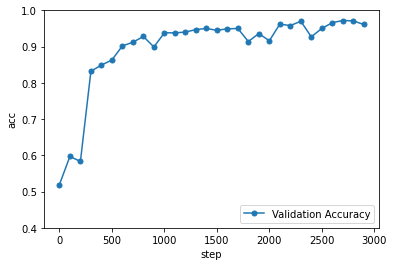

In [22]:
plt.plot(valid_x_axis, valid_acc, marker='o', ms=5, label='Validation Accuracy')
plt.ylabel('acc')
plt.xlabel('step')
plt.ylim(0.4,1)
plt.legend(loc='lower right')

In [23]:
# Prediction on test set

print('Predicting labels for test dataset...')

# Put model in evaluation mode
model.eval()

test_acc, _ = performance(model, device, test_loader)

print('Test ACC : ', test_acc)

Predicting labels for test dataset...
Test ACC :  0.972


Submission File

In [24]:
df = pd.read_csv('./test.csv')

In [28]:
data = pd.DataFrame.to_numpy(df)

In [33]:
data[0, 2]

'N,K = map(int,input().split())\nA = list(map(int,input().split()))\nprint((len(A)-1)//(K-1) + int(bool((len(A)-1)%(K-1))))'

In [43]:
class Test_Code():
    def __init__(self, path):
        self.path = path
            
    def openFile(self):
        df = pd.read_csv(self.path+'test.csv')

        # dataframe to ndarray
        data = pd.DataFrame.to_numpy(df)

        return data

class test_code_dataset(Dataset):
    def __init__(self, data):

        input_ids = []
        attn_masks = []

        for i in range(len(data)):
            tmp = tokenizer(data[i, 1], data[i,2], padding='max_length', truncation=True, return_tensors='pt')
            input_ids.append(tmp['input_ids'])
            attn_masks.append(tmp['attention_mask'])
        
        self.input_ids = torch.cat(input_ids, out=torch.Tensor(len(input_ids), 512)).type(torch.LongTensor)
        self.attn_masks = torch.cat(attn_masks, out=torch.Tensor(len(attn_masks), 512)).type(torch.LongTensor)
        self.pair_ids = torch.from_numpy(data[:, 0].astype(int))

    def __getitem__(self, index):
        return self.input_ids[index], self.attn_masks[index], self.pair_ids[index]

    def __len__(self):
        return len(self.pair_ids)

def test_dataset_loader(path, batch_size):
    code = Test_Code(path)

    data = code.openFile()

    dataset = test_code_dataset(data)

    data_loader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=False)

    return data_loader

def test_dataloader_testing():
    # dataloader test
    path = './'
    data_loader = test_dataset_loader(path=path, batch_size=16) # batch_size = 10 (toy example)

    data = next(iter(train_loader))

    print('Batch Size :', len(data[0]))
    print('input_ids: ', type(data[0]),'\n', data[0])
    print('attn_masks :', type(data[1]),'\n', data[1])
    print('pair_ids :', type(data[2]), '\n', data[2])

In [44]:
path = './'
data_loader = test_dataset_loader(path=path, batch_size=16)

In [112]:
activation = nn.Softmax(dim=1)
predictions = []
pair_ids_list = []

model.eval()

count = 0

for batch in data_loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_pair_ids = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs[0]
    logits = activation(logits)
    tmp_logits = torch.max(logits, dim=1)
    pred = tmp_logits[1]
    pred = pred.detach().cpu().numpy()
    predictions.append(pred)
    pair_ids_list = pair_ids_list + b_pair_ids.tolist()
    count += 1
    if count % 10 == 0:
        print('batch {} over {}'.format(count, len(data_loader)))

batch 10 over 11232
batch 20 over 11232
batch 30 over 11232
batch 40 over 11232
batch 50 over 11232
batch 60 over 11232
batch 70 over 11232
batch 80 over 11232
batch 90 over 11232
batch 100 over 11232
batch 110 over 11232
batch 120 over 11232
batch 130 over 11232
batch 140 over 11232
batch 150 over 11232
batch 160 over 11232
batch 170 over 11232
batch 180 over 11232
batch 190 over 11232
batch 200 over 11232
batch 210 over 11232
batch 220 over 11232
batch 230 over 11232
batch 240 over 11232
batch 250 over 11232
batch 260 over 11232
batch 270 over 11232
batch 280 over 11232
batch 290 over 11232
batch 300 over 11232
batch 310 over 11232
batch 320 over 11232
batch 330 over 11232
batch 340 over 11232
batch 350 over 11232
batch 360 over 11232
batch 370 over 11232
batch 380 over 11232
batch 390 over 11232
batch 400 over 11232
batch 410 over 11232
batch 420 over 11232
batch 430 over 11232
batch 440 over 11232
batch 450 over 11232
batch 460 over 11232
batch 470 over 11232
batch 480 over 11232
b

In [123]:
predictions_flat = [item for sublist in predictions for item in sublist]

In [124]:
import pickle

with open('./predictions.pkl', 'wb') as f:
    pickle.dump(predictions_flat, f)

with open('./pair_ids.pkl', 'wb') as f:
    pickle.dump(pair_ids_list, f)

In [126]:
print(len(predictions_flat))
print(len(pair_ids_list))

179700
179700


In [130]:
import csv

f = open('submission_05_17.csv','w', newline='')
wr = csv.writer(f)
wr.writerow(['pair_id','similar'])
for i in range(len(pair_ids_list)):
     wr.writerow([pair_ids_list[i],predictions_flat[i]])
f.close()